In [1]:
import math
import numpy as np
import numpy.random as npr
from numpy import linalg
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils import data
from torch.utils.data import Dataset
import torch.optim as optim
import time
from math import *
torch.cuda.set_device(0)

In [2]:
torch.set_default_tensor_type('torch.DoubleTensor')

In [3]:
class ResNet(nn.Module):
    def __init__(self,dim, m,o):
        super(ResNet, self).__init__()
        self.Ix = torch.zeros([dim,m]).cuda()
        self.Ix[0,0] = 1
        self.Ix[1,1] = 1
        self.fc1 = nn.Linear(dim, m)
        self.fc2 = nn.Linear(m, m)
        
        self.fc3 = nn.Linear(m, m)
        self.fc4 = nn.Linear(m, m)

        
        self.outlayer = nn.Linear(m, o)

    def forward(self, x):
        s = x@self.Ix
        y = self.fc1(x)
        y = F.relu(y**deg)
        y = self.fc2(y)
        y = F.relu(y**deg)
        y = y+s
        
        s=y
        y = self.fc3(y)
        y = F.relu(y**deg)
        y = self.fc4(y)
        y = F.relu(y**deg)
        y = y+s
        
        
        output = self.outlayer(y)
        return output
deg = 2

In [4]:
def sol_exact(x):
    x_tem = torch.cos(pi*x[:,1:dim_set])
    sol = torch.sum(x_tem,dim=1).reshape([x.size()[0],1])
    return sol * (x[:,0:1]+ 2/5)*(1-x[:,0:1])*(x[:,0:1]+x[:,1:2])*(x[:,0:1]-x[:,1:2]+1)*(x[:,1:2])*(x[:,1:2]-1)

In [5]:
def sol_exact_H1(x):
    sol = torch.zeros(x.size()[0],dim_set+1).cuda()
    x.requires_grad = True
    u = sol_exact(x)
    sol[:,0:1] =  u
    v= torch.ones(u.shape).cuda()
    sol[:,1:dim_set+1] = torch.autograd.grad(u,x,grad_outputs=v,create_graph=True)[0]
    return sol

In [6]:
def right(x):
    du = sol_exact_H1(x)[:,1:dim_set+1]
    v= torch.ones([x.shape[0],1]).cuda()
    uxx = torch.zeros(Batch_size,dim_set).cuda()
    for i in range(dim_set):
        ux_tem = du[:,i].reshape([x.size()[0],1])
        uxx_tem = torch.autograd.grad(ux_tem,x,grad_outputs=v,create_graph=True)[0]
        uxx[:,i] = uxx_tem[:,i]
    return torch.sum(uxx,dim=1).reshape([x.size()[0],1])

In [7]:
def DataGen(BatchSize):
    x = torch.rand(BatchSize,dim_set)
    x[:,0:1] = 7/5*x[:,0:1] - 2/5
    index = (x[:,0:1]+x[:,1:2] >0)* (x[:,0:1]-x[:,1:2]+1>0)
    return index*x + ~index * torch.rand(BatchSize,dim_set)

In [8]:
dim_set = 16
Batch_size = 50000
def DRM1():
    x = DataGen(Batch_size).cuda()
    x.requires_grad = True
    u = model_u(x)
    du = model_p(x)
    v= torch.ones(u.shape).cuda()
    ux = torch.autograd.grad(u,x,grad_outputs=v,create_graph=True)[0]
    loss1 = torch.sum((ux-du)**2)/Batch_size
    return loss1

In [9]:
def DRM2():
    x = DataGen(Batch_size).cuda()
    x.requires_grad = True
    u = model_u(x)
    du = model_p(x)
    v= torch.ones(u.shape).cuda()
    uxx = torch.zeros(Batch_size,dim_set).cuda()
    for i in range(dim_set):
        ux_tem = du[:,i].reshape([x.size()[0],1])
        uxx_tem = torch.autograd.grad(ux_tem,x,grad_outputs=v,create_graph=True)[0]
        uxx[:,i] = uxx_tem[:,i]
    loss2 = torch.sum((torch.sum(uxx,dim=1).reshape([x.size()[0],1])  - right(x))**2)/Batch_size
    return loss2

In [10]:
def model_p(x):
    multi = x*(1-x)
    multi[:,0:2] = 1
    return model_p1(x)*multi

In [11]:
def model_u(x):
    return (x[:,0:1]+ 2/5)*(1-x[:,0:1])*(x[:,0:1]+x[:,1:2])*(x[:,0:1]-x[:,1:2]+1)*(x[:,1:2])*(x[:,1:2]-1)*model_u1(x) 

In [12]:
model_u1 = ResNet(dim_set,40,1)
model_p1 = ResNet(dim_set,40,dim_set)

device=torch.device("cuda:0" )
model_u1.to(device)
model_p1.to(device)

ResNet(
  (fc1): Linear(in_features=16, out_features=40, bias=True)
  (fc2): Linear(in_features=40, out_features=40, bias=True)
  (fc3): Linear(in_features=40, out_features=40, bias=True)
  (fc4): Linear(in_features=40, out_features=40, bias=True)
  (outlayer): Linear(in_features=40, out_features=16, bias=True)
)

In [13]:
notes = DataGen(10000).cuda()
exact = sol_exact_H1(notes)
u_L2 = sqrt(torch.sum((exact[:,0])**2)/10000)
Du_L2 = sqrt(torch.sum(exact[:,1:3]**2)/10000)
def loss_error():
    notes = DataGen(10000).cuda()
    predict = torch.zeros(10000,2*dim_set+2).cuda()
    predict[:,0]= model_u(notes).reshape([1,notes.size()[0]])
    predict[:,1:dim_set+1]= model_p(notes)
    exact = sol_exact_H1(notes)
    value1 = sqrt(torch.sum((predict[:,0] - exact[:,0])**2)/10000)/u_L2
    value2 = sqrt(torch.sum((predict[:,1:3] - exact[:,1:3])**2)/10000)/Du_L2
    return value1,value2

In [14]:
traintime = 40000
error_save=np.zeros([2,traintime])
optimizer = optim.Adam([
                {'params': model_u1.parameters()},
                {'params': model_p1.parameters()},
            ])
time_start=time.time()
for i in range(traintime):
    optimizer.zero_grad()
    losses1 = DRM1()
    losses1.backward()
    optimizer.step() 
    optimizer.zero_grad()
    losses2 = DRM2()
    losses2.backward()
    optimizer.step() 
    error1,error2 = loss_error()
    error_save[0,i]=float(error1)
    error_save[1,i]=float(error2)
    #scheduler.step()
    if i%500==1:
        print("i= ",i)
        print("error =",error1)
        print("loss1 =",losses1.detach())
        print("loss2 =",losses2.detach())
        np.save("error_save_LDG_NBC_16D_v2.npy", error_save)
np.save("error_save_LDG_NBC_16D_v2.npy", error_save)
time_end=time.time()
print('time cost',time_end-time_start,'s')

i=  1
error = 1.0234450719021995
loss1 = tensor(0.0444, device='cuda:0')
loss2 = tensor(26.6623, device='cuda:0')
i=  501
error = 0.1656465135806278
loss1 = tensor(0.3321, device='cuda:0')
loss2 = tensor(1.0002, device='cuda:0')
i=  1001
error = 0.14035420722954353
loss1 = tensor(0.1556, device='cuda:0')
loss2 = tensor(0.4171, device='cuda:0')
i=  1501
error = 0.12862066835615021
loss1 = tensor(0.0919, device='cuda:0')
loss2 = tensor(0.3732, device='cuda:0')
i=  2001
error = 0.15925872446066033
loss1 = tensor(0.0633, device='cuda:0')
loss2 = tensor(0.3561, device='cuda:0')
i=  2501
error = 0.09265853357746376
loss1 = tensor(0.0453, device='cuda:0')
loss2 = tensor(0.3348, device='cuda:0')
i=  3001
error = 0.08375053729470278
loss1 = tensor(0.0354, device='cuda:0')
loss2 = tensor(0.3277, device='cuda:0')
i=  3501
error = 0.07230979761979597
loss1 = tensor(0.0310, device='cuda:0')
loss2 = tensor(0.3179, device='cuda:0')
i=  4001
error = 0.0492903208777771
loss1 = tensor(0.0271, device='cu

i=  35001
error = 0.019138959006464767
loss1 = tensor(0.0136, device='cuda:0')
loss2 = tensor(0.0098, device='cuda:0')
i=  35501
error = 0.015536490930514076
loss1 = tensor(0.0132, device='cuda:0')
loss2 = tensor(0.0071, device='cuda:0')
i=  36001
error = 0.01985091557051726
loss1 = tensor(0.0132, device='cuda:0')
loss2 = tensor(0.0165, device='cuda:0')
i=  36501
error = 0.018361283461845596
loss1 = tensor(0.0132, device='cuda:0')
loss2 = tensor(0.0069, device='cuda:0')
i=  37001
error = 0.010468021054502697
loss1 = tensor(0.0129, device='cuda:0')
loss2 = tensor(0.0036, device='cuda:0')
i=  37501
error = 0.020346070455485487
loss1 = tensor(0.0130, device='cuda:0')
loss2 = tensor(0.0114, device='cuda:0')
i=  38001
error = 0.010794121882218965
loss1 = tensor(0.0130, device='cuda:0')
loss2 = tensor(0.0038, device='cuda:0')
i=  38501
error = 0.012553236787778746
loss1 = tensor(0.0127, device='cuda:0')
loss2 = tensor(0.0043, device='cuda:0')
i=  39001
error = 0.04549364453782225
loss1 = ten

In [15]:
import matplotlib.pyplot as plt

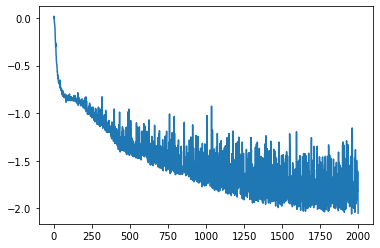

In [16]:
index = np.arange(0,20000,10)
plt.plot(np.log10(error_save[0,index]))

In [17]:
def model_u(x):
    return sol_exact_H1(x)[:,0:1]
def model_p(x):
    return sol_exact_H1(x)[:,1:dim_set+1]